# Examen Final - Teoría de Sistemas de Control - UTEC - 2020-1

**Alumno**: Bregy Malpartida

**Stack**: Python3.8, Numpy, Matplotlib, Control, Control2020, Scipy, Jupyter, IPython

---

In [79]:
import numpy as np
import control as ct
import control2020 as ct20
from matplotlib import pyplot as plt
%matplotlib inline

## Pregunta 1
Se tiene el siguiente sistema en lazo abierto
$$G(s)=\frac{0.3(s+2)}{s(s+45)(s+6.2)(s+0.7)}$$

### 1.a
Diseñe un compensador en la frecuencia de modo a obtener un Kv de 40 y un %OS menor al 10%. Justifique que compensador utilizará. Muestre la gráfica del error a la rampa y el diagrama de bode indicando los márgenes. Use el tiempo de simulación que crea conveniente.

**Solución**

In [80]:
s = ct.TransferFunction([1, 0], [1])
g = 0.3*(s+2)/s/(s+45)/(s+6.2)/(s+0.7)
display(g)


            0.3 s + 0.6
------------------------------------
s^4 + 51.9 s^3 + 314.8 s^2 + 195.3 s

In [81]:
po = 10
kv = 40
err_ramp_expected = 1/kv

log_po = np.log(100 / po)
psi = log_po / np.sqrt(np.pi ** 2 + log_po ** 2)
print(psi)
print("Phase Margin=", 100*psi)
print("Ramp error ss=", err_ramp_expected)

0.5911550337988976
Phase Margin= 59.11550337988976
Ramp error ss= 0.025


Como podemos apreciar, necesitamos un margen de fase de almenos 59deg, teniendo en cuenta que el margen de fase actual es de 89deg, usaré un lag compensator para reducir dicho margen de fase.

In [82]:
compensator = ct20.design.frequency.lag_compensator(g, err_ramp=err_ramp_expected, psi=psi)
display(compensator)

1 states have been removed from the model
kc= 13019.999999999989
phi= -1.9876594329972777
wcg= 0.42919342601287785
A= -38.17654153620822



3.034e+05 s + 1.302e+04
-----------------------
      1889 s + 1

##### Resultado

gm= 222.97527450706173 | pm= 60.40088255697984


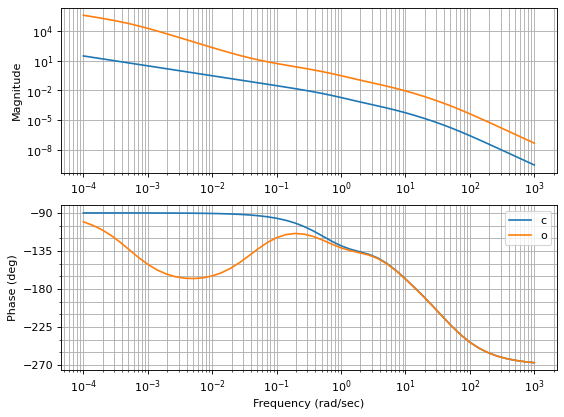

In [83]:
gm, pm, _, _ = ct.margin(g*compensator)
print("gm=",gm,"|", "pm=",pm)
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(g, omega=np.logspace(-4, 3))
_ = ct.bode(g*compensator, omega=np.logspace(-4, 3))
plt.legend("sin compesador")
plt.legend("cont compesador");

Como se puede apreciar, el compensador consiguio un margen de fase de 60 que esta muy cercano a lo que necesitabamos (59.11)

0.025185153501524837


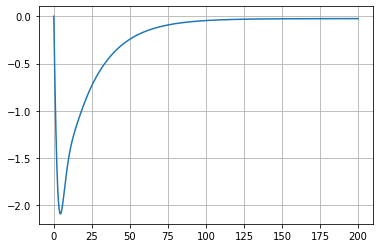

In [84]:
sys = ct.feedback(g*compensator, 1)

t = np.linspace(0, 200, 1000)
u = t

t, y, _ = ct.forced_response(sys, t, u)
error = y - u

print(abs(error[-1]))
plt.plot(t, error)
plt.grid()

Como se puede apreciar en la gráfica del error a la rampa, para un tiempo de 200 segundos (aproximadamente) el error se estabiliza en 0.025 (1/40), lo cual cumple con el requerimiento.

---

### 1.b

Determine en caso sea posible agregar una ganancia proporcional al sistema en lazo abierto controlado (Gc(s)G(s)) para lograr un margen de fase de 70deg.

**Solución**

Primero, veamos el margen de fase de nuestro sistema

In [85]:
gm, pm, _, _ = ct.margin(g*compensator)
print("pm=", pm)

pm= 60.40088255697984


En este caso, especificamente, nos piden un margen de fase de 70deg, por lo tanto se ubicará la magnitud que coincide en la frecuencia que satisface el requisito de pm.

In [86]:
sys_open_loop = g*compensator
gain = ct20.design.frequency.frequency_requirements(sys_open_loop, phase_margin=70*np.pi/180)
print("gain=", gain)
gm, pm, _, _ = ct.margin(gain*sys_open_loop)
print("pm=", pm)

gain= 5.415832845799037e-06
pm= 69.34013555822287


Como se puede apreciar, con una ganancia de ~5.4e-6 se consigue un pm de 69deg, no es lo que pide el problema con exactitud, pero esta muy cerca, solo haciendo algunos ajustes se puede conseguir el valor de 70deg exactos.

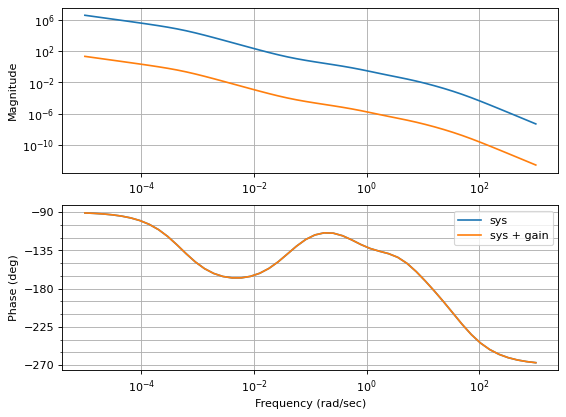

In [87]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(sys_open_loop)
_ = ct.bode(gain*sys_open_loop)
plt.legend(["sys", "sys + gain"]);

Con una ganancia de 5.415e-6 se consigue el margen de fase esperado.

Como se puede ver, la ganancia escogida deplaza el cruce en cero de la magnitud (ancho de banda) a la izquierda consiguiendo el requerimiento de 70deg.

---

### 1.c

Diseñe y muestre el controlador PID por el método analítico en la frecuencia, considerando un error estacionario a la rampa unitaria de 0.1, %OS<10% (asociado a un margen de fase deseado), tiempo de establecimiento al 2% de 6 seg. El controlador debe cumplir los requerimientos en la frecuencia. Muestre el diagrama de bode indicando los márgenes y la respuesta al escalón indicando el %OS y el tiempo de establecimiento. ¿Qué puede concluir de los resultados obtenidos? Use el tiempo de simulación que crea conveniente.

**Solución**

Recordando el sistema G(s)

In [88]:
display(g)


            0.3 s + 0.6
------------------------------------
s^4 + 51.9 s^3 + 314.8 s^2 + 195.3 s

In [89]:
pid = ct20.design.frequency.pid_by_frequency(g, po=10, ts=6, err_para=0.1)
display(pid)

2 states have been removed from the model
ki= 3254.9999999999973
wn= 1.127735752130053 psi= 0.5911550337988976
pm= 59.11550337988976, ki= 3254.9999999999973, kp= 607.7839008846938, kd= 2650.6835926339136



2651 s^2 + 607.8 s + 3255
-------------------------
            s

Como se puede apreciar, para los requerimientos propuestos (po=10%, ts=6) se calculó un margen de fase necesario de 59deg.

A continuación se muestra el diagrama de bode y el margen de fase conseguido por el sistema pid\*g (en lazo abierto)

pm= 58.15365437441113


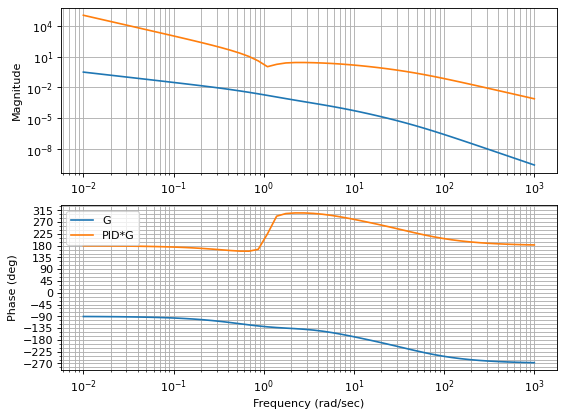

In [90]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(g)
_ = ct.bode(pid*g)
plt.legend(["G", "PID*G"])
_, pm, _, _ = ct.margin(pid*g)
print("pm=", pm)

El margen de fase conseguido (pm=58.1536) es muy cercano al esperado (59.11)

A continuación veremos los resultados conseguidos para el tiempo de establecimiento y porcentaje de overshoot. He intentado bastante tunear, sin embargo, se me ha complicado conseguir los requisitos propuestos por el problema, más abajo haré un analisis de porque creo que es muy complicado conseguir los requerimientos impuestos. 

Cabe resaltar que como vimos arriba, el controlador **sí** ccumple con los requisitos en frecuencia.

{'RiseTime': 0.4937894241025024,
 'SettlingTime': 48.391363562045235,
 'SettlingMin': 0.8671594374316118,
 'SettlingMax': 1.1493524499650176,
 'Overshoot': 14.94041454227024,
 'Undershoot': 0.0,
 'Peak': 1.1493524499650176,
 'PeakTime': 2.304350645811678,
 'SteadyStateValue': 0.9999550241245513}

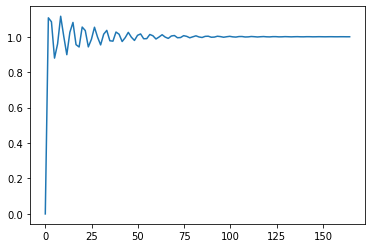

In [91]:
sys_closed_loop = ct.feedback(pid*g, 1)
plt.plot(*ct.step_response(sys_closed_loop))
ct.step_info(sys_closed_loop)

Directamente, usando po=10 y ts=6 no pude conseguir dichos valor, conseguí un po=14.9 (1.5 veces más) y un ts=48 (8 veces más).

0.1259551007533446


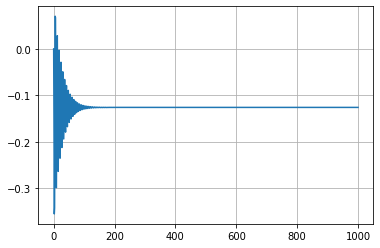

In [92]:
t = np.linspace(0, 1000, 1000)
u = t**2

t, y, _ = ct.forced_response(sys_closed_loop, t, u)
error = y - u

print(abs(error[-1]))
plt.plot(t, error)
plt.grid()

Como se puede apreciar en la gráfica de error( arriba), el error a la parabola en estado estable es de aproximadamente 0.12, el requerimiento era de 0.10, no está muy alejado, pero de todas formas no cumple estrictamente el requerimiento.

---

## Pregunta 2
Se tiene el siguiente sistema en lazo abierto

$$G(s)=\frac{2(s+3)}{(s+1)(s+0.1)(s+0.5)}$$

### 2.a

Diseñe un controlador por realimentación de estados (rastreador) con efecto integrador con observador, de modo a obtener un %OS menor al 12% y un tiempo de establecimiento menor a 5 seg. Muestre la respuesta al escalón unitario indicando si cumplió los requerimientos.

**Solución**

In [93]:
g = 2*(s+3)/(s+1)/(s+0.1)/(s+0.5)
display(g)


           2 s + 6
-----------------------------
s^3 + 1.6 s^2 + 0.65 s + 0.05

In [94]:
sys = ct.tf2ss(g)
print("A=")
print(sys.A)
print("")
print("B=")
print(sys.B)
print("")
print("C=")
print(sys.C)
print("")
print("D=")
print(sys.D)

A=
[[-1.6  -0.65 -0.05]
 [ 1.    0.    0.  ]
 [ 0.    1.    0.  ]]

B=
[[1.]
 [0.]
 [0.]]

C=
[[0. 2. 6.]]

D=
[[0.]]


A continuación, construiremos el sistema en lazo cerrado con observador, para po=10 y ts=5, además, como el sistema requiere de dos polos adicionales situaré estos en -10 y -15

In [111]:
# po < 12% => po=10, ts=5
close_loop_system_w_obs = ct20.design.statespace.tracker_with_observer(
    sys, po=10, ts=5, extra_poles=[-10, -15]
)

rank= 4
k= [[ 26.20000137 191.80137516 285.7843654 ]]
ki= 137.3530960762923
obs_rank= 3

L=
[[  81209.97454352]
 [1859140.93760217]
 [6839269.02145894]]


Como se puede ver, la matriz L, corresponde al observador generado

Veamos como quedaron las matrices del sistema final en lazo cerrado con el rastreador y observador:

In [96]:
close_loop_system_w_obs

A = [[-1.60000000e+00 -6.50000000e-01 -5.00000000e-02 -2.50000005e+01
  -1.91181375e+02 -1.94165635e+02  4.57843654e+01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.43372354e+04  1.93011706e+05 -2.66000005e+01
  -6.45290668e+04 -1.93205922e+05  4.57843654e+01]
 [ 0.00000000e+00 -4.08515262e+04 -1.22554579e+05  1.00000000e+00
   4.08515262e+04  1.22554579e+05  0.00000000e+00]
 [ 0.00000000e+00  8.75193564e+05  2.62558069e+06  0.00000000e+00
  -8.75192564e+05 -2.62558069e+06  0.00000000e+00]
 [-0.00000000e+00 -2.00000000e+00 -6.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

C = [[0.e+00 2.e+00 6.e+00 0.e+00 0.e+00 0.e+00 1.e-06]]

D = [[0.]]

{'RiseTime': 1.2082024180570792,
 'SettlingTime': 4.166521574035074,
 'SettlingMin': 0.9017328666686885,
 'SettlingMax': 1.1130772277547296,
 'Overshoot': 11.202347472262188,
 'Undershoot': 0.0,
 'Peak': 1.1130772277547296,
 'PeakTime': 2.638500868845239,
 'SteadyStateValue': 1.0009475996290191}

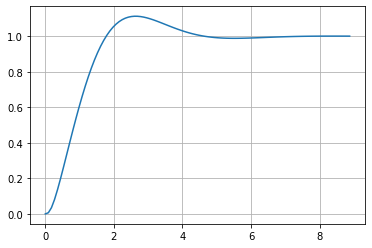

In [97]:
plt.plot(*ct.step_response(close_loop_system_w_obs))
plt.grid()
ct.step_info(close_loop_system_w_obs)

Como se puede apreciar, la respues al escalon cumple con los requerimientos esperados en tiempo po=11.2 (<12) y ts=4 (<5).

### 2.a

Diseñe un controlador por realimentación de estados (rastreador) con efecto integrador con observador, de modo a obtener un %OS menor al 12% y un tiempo de establecimiento menor a 5 seg. Muestre la respuesta al escalón unitario indicando si cumplió los requerimientos.

**Solución**

Podemos apreciar que los polos están situados en donde queríamos.

In [98]:
_ = ct.damp(close_loop_system_w_obs)

_____Eigenvalue______ Damping___ Frequency_
-2.585e+06                     1  2.585e+06
       -15                     1         15
       -10                     1         10
      -0.8    +1.091j     0.5912      1.353
      -0.8    -1.091j     0.5912      1.353
   -0.7887   +0.1416j     0.9843     0.8013
   -0.7887   -0.1416j     0.9843     0.8013


El sistema es estable y presenta un comportamiento del tipo amortiguado gracias a los polos complejos conjugados (que son los dominnates).

### 2.b

Muestre las gráficas de los estados reales y los estados estimados del sistema controlado. ¿Qué puede concluir de sus gráficas?

**Solución**

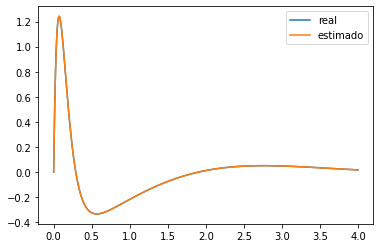

In [99]:
t = np.linspace(0, 4, 1000)
u = np.zeros_like(t)
t,y,x = ct.forced_response(close_loop_system_w_obs, t, u, X0=[0, 0, 0, 0, 0, 0, 1])

plt.plot(t, x[0, :])
plt.plot(t, x[3, :])
plt.legend(["real", "estimado"])

Como se puede ver, ambas gráficas estan completamente superpuestas, esto quiere decir que el observador cumplio el objetivo de otorgar una correcta emulación de los estados del sistema.

## Pregunta 3
Se tiene el siguiente sistema en lazo abierto

$$G(s)=\frac{2}{s(s+0.1)(s+0.3)}$$

###  3.a

Diseñe un controlador por realimentación de estados (regulador) con observador, de modo a obtener un %OS menor al 10% y un tiempo de establecimiento menor a 4 seg. Muestre la respuesta a una condición inicial que crea conveniente. Muestre las gráficas de los estados reales y los estados estimados del sistema controlado. ¿Qué puede concluir de sus gráficas?

In [100]:
g = 2/s/(s+0.1)/(s+0.3)
display(g)


          2
----------------------
s^3 + 0.4 s^2 + 0.03 s

In [101]:
sys = ct.tf2ss(g)

In [112]:
closed_loop_w_regulator = ct20.design.statespace.regulator_with_observer(
    sys, po=8, ts=3, extra_poles=[-10]
)

obs_rank= 3

L=
[[1.84568931e+07]
 [1.63879205e+08]
 [3.72862174e+08]]


In [103]:
closed_loop_w_regulator

A = [[-4.00000000e-01 -3.00000000e-02 -0.00000000e+00 -1.22666667e+01
  -3.11648950e+01 -4.52822832e+01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.69137862e+07 -1.26666667e+01
  -3.11948950e+01 -3.69138315e+07]
 [ 0.00000000e+00  0.00000000e+00  3.27758410e+08  1.00000000e+00
   0.00000000e+00 -3.27758410e+08]
 [ 0.00000000e+00  0.00000000e+00  7.45724347e+08  0.00000000e+00
   1.00000000e+00 -7.45724347e+08]]

B = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

C = [[0. 0. 2. 0. 0. 0.]]

D = [[0.]]

A continuación se pueden ver las gráficas para dos distintas condiciones iniciales del sistema con regulador y observador, vease que cumple con el requisito de regulador ya que siempre regresa a la posición de equilibrio (0).

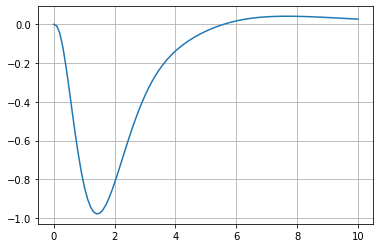

In [104]:
t = np.linspace(0, 10, 100)
t, y = ct.initial_response(closed_loop_w_regulator, X0=[0, 0, 0, 0, 1, 0], T=t)
plt.plot(t, y)
plt.grid()

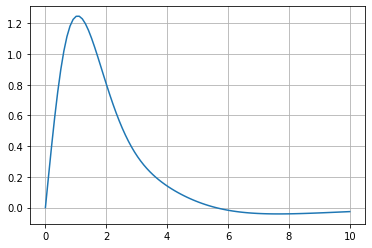

In [105]:
t = np.linspace(0, 10, 100)
t, y = ct.initial_response(closed_loop_w_regulator, X0=[0, 1, 0, 0, 0, 0], T=t)
plt.plot(t, y)
plt.grid()

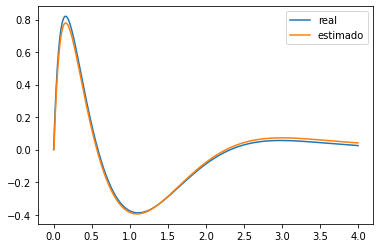

In [109]:
t = np.linspace(0, 4, 1000)
u = np.zeros_like(t)
t,y,x = ct.forced_response(closed_loop_w_regulator, t, u, X0=[0, 0, 0, 0, 0, 1])

plt.plot(t, x[0, :])
plt.plot(t, x[3, :])
plt.legend(["real", "estimado"])

En este caso, podemos ver que el observador a logrado generar una curva muy parecida a la de uno de los estados internos del sistema, sin embargo, es bastante aceptable el desempeño de este observador.

### 3.b

Muestre los polos del sistema en lazo cerrado e indique la estabilidad y el tipo de comportamiento temporal según sus polos dominantes.

In [110]:
_ = ct.damp(closed_loop_w_regulator)

_____Eigenvalue______ Damping___ Frequency_
    -4.041                     1      4.041
     1.821    +3.381j    -0.4741       3.84
     1.821    -3.381j    -0.4741       3.84
-7.457e+08                     1  7.457e+08
    -4.077                     1      4.077
    -9.029                     1      9.029


Los polos domunantes son los dos polos complejos conjugados $-1.821 \pm 3.381j$. Esto significa que el sistema tiene un comportamiento subamortiguado.